<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Fall2023/blob/main/Module%204/11_PCA_GenerativeModel_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial notebook for the Fall 2023 Course "Machine Learning for Materials Science", University of Tennessee Knoxville, Department of Materials Science and Engineering.

- Instructor Sergei V. Kalinin

# PCA on images

Now, let's see how PCA can work on an image data set. Here, we use the most basic of the handwritten digits data sets available from scikit-learn.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
import keras
X, y = keras.datasets.mnist.load_data()[0]
X = X.reshape(60000, 784)

11490434/11490434 [==============================] - 0s 0us/step


Let's examine the shape of the data and structure of the data set. Note that for practical applications if you apply ML to your own problems, it is very convenient to strucutre the data set similarly to these examples. Then the codes can be used directly.

In [3]:
X.shape, y.shape

((60000, 784), (60000,))

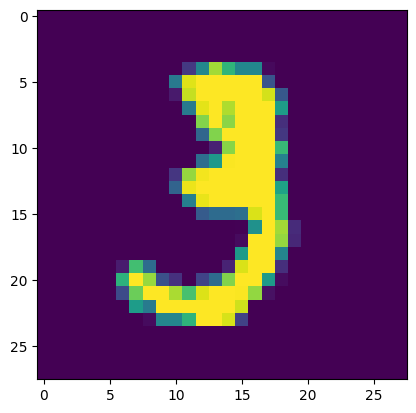

In [4]:
plt.imshow(X[10,:].reshape(28,28))

Now we perform the PCA. Experiment with anf without scaling.

In [5]:
# Standardize the features
#X = StandardScaler().fit_transform(X)

# Perform PCA
pca = PCA(n_components=10)
X_pca = pca.fit(X)

In [6]:
print(X_pca.explained_variance_ratio_)

[0.09704664 0.07095924 0.06169089 0.05389419 0.04868797 0.04312231
 0.0327193  0.02883895 0.02762029 0.02356995]


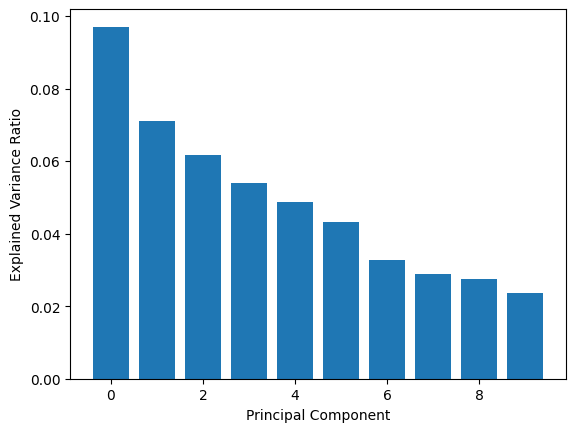

In [7]:
# prompt: bar plot of explained variance ratio'

plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()


In [8]:
X_pca.get_covariance().shape

(784, 784)

PCA scores is a very interesting object, and appears becasue scikit learn tries to use Bayesian methods to perform PCA. It allows to calculate probability of the data based on the amount of variance it explains. It is not necessary for simple applications, but allows to expand PCA for more complex applications.

In [9]:
X_pca.score_samples(X).shape

(60000,)

Now, let's transform the data and explroe components. Do not forget to .reshape(8,8) to go flom line vectors to images

In [10]:
X_t = X_pca.transform(X)
X_t.shape

(60000, 10)

In [11]:
X_pca.components_.shape

(10, 784)

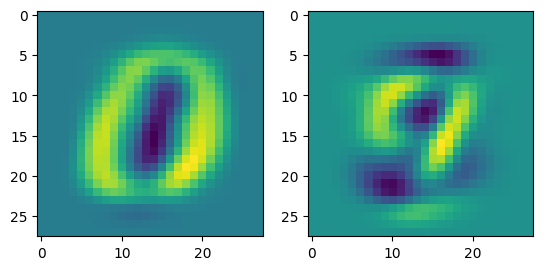

In [12]:
X_ti = X_pca.components_

fig, ax = plt.subplots(1, 2)
ax[0].imshow(X_ti[0,:].reshape(28,28))
ax[1].imshow(X_ti[1,:].reshape(28,28))
plt.show()

Now, let's look at the PCA components with ground truth labels. Note that we can see clusters!

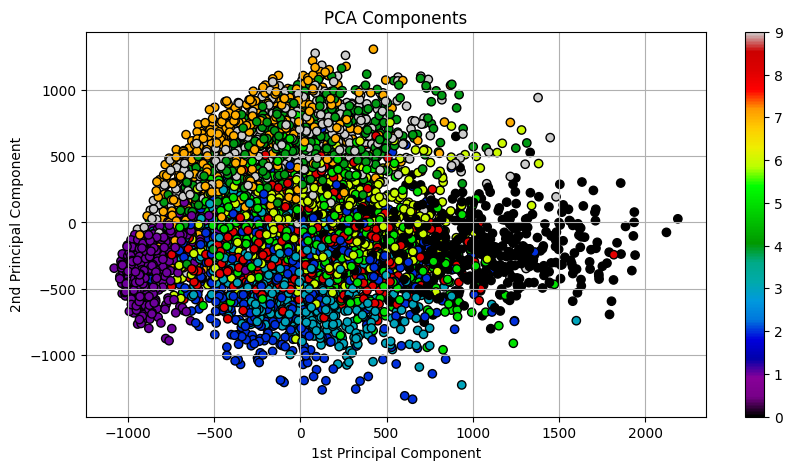

In [13]:
# Plot the PCA components
plt.figure(figsize=(10, 5))
plt.scatter(X_t[::10, 0], X_t[::10, 1], c=y[::10], cmap=plt.cm.nipy_spectral, edgecolor='k')
plt.colorbar()
plt.title("PCA Components")
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")
plt.grid(True)
plt.show()

# Clustering in reduced space

Now, let's truncate the PCA expansion to 2 components, and do k-means clustering into 10 components. We hope to separate clusters based on data only (unlike previous examples, we do not have labels for the k-means). Then we build decision surface for k-means (this is why we keep only 2 dimensions), and compare the ground truth labels and k-means classification results.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


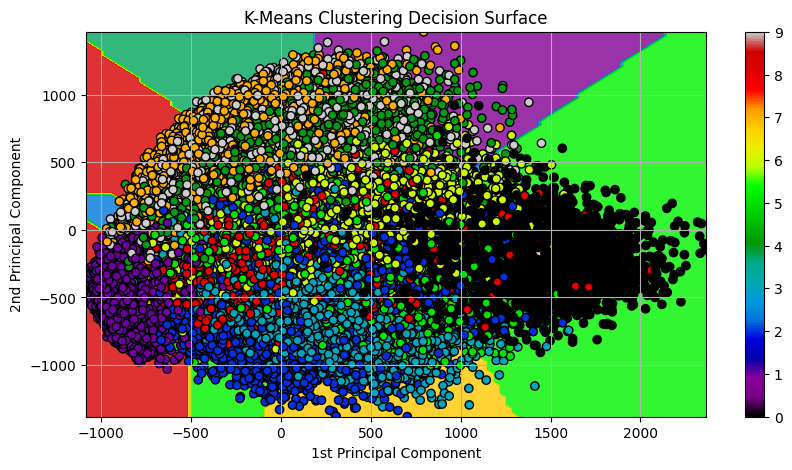

In [14]:
X_t = X_t[:,:2]

# Perform K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=0)  # Assuming 10 clusters for 10 digits
kmeans.fit(X_t)

# Plot the decision surface
plt.figure(figsize=(10, 5))
x_min, x_max = X_t[:, 0].min() - 1, X_t[:, 0].max() + 1
y_min, y_max = X_t[:, 1].min() - 1, X_t[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.nipy_spectral, alpha=0.8)
plt.scatter(X_t[:, 0], X_t[:, 1], c=y, cmap=plt.cm.nipy_spectral, edgecolor='k')
plt.colorbar()
plt.title("K-Means Clustering Decision Surface")
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")
plt.grid(True)
plt.show()

# Our first generative model

And now let's make our first generative model.
- Here we train PCA with 2 components only. These components will be the same for n = 2 or n = 10 (rememebr that PCA performs the expansion and then truncates; for other dimensionality reduction methods such as NMF it will be different).
- We then use the image above as a guide to select certain point in the PCA (latent) space.
- Then we apply inverse transform of the chosen point (that was **not** a part of original data set)
- Presto! We created a new digit which is **like** the ones before, but was not a part of the original data set.
- We still have a long road to MidJourney and DALLE2, of course....

(784,)


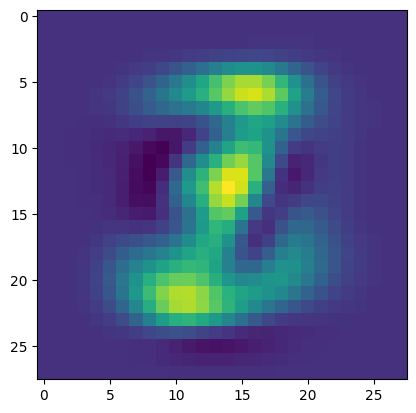

In [15]:
pca = PCA(n_components=2)
X_pca_2 = pca.fit(X)

X_rec = X_pca_2.inverse_transform((-250, -1000))
print(X_rec.shape)
plt.imshow(X_rec.reshape(28,28))

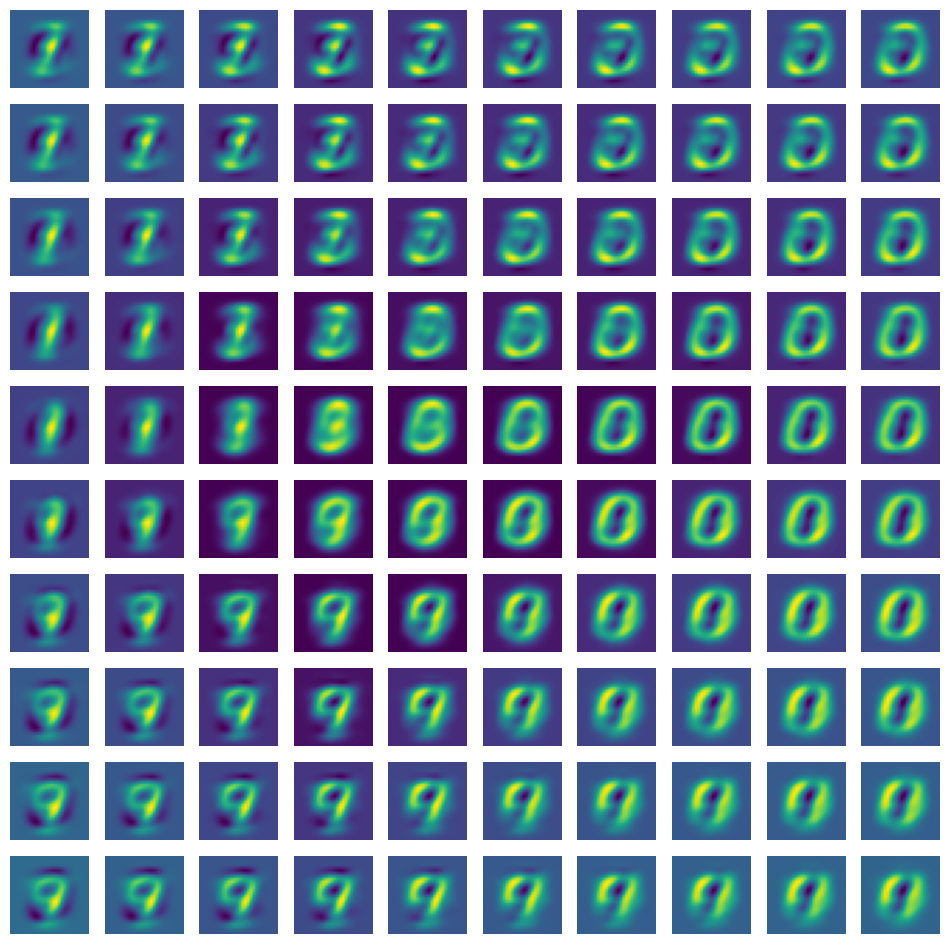

In [16]:
# prompt: sample latent space of the PCA using 10x10 grid, decode the images from the latent space, and plot them as 10x10 table

X_t = X_t[:,:2]

# Generate a grid of latent space points
x_min, x_max = X_t[:, 0].min() - 1, X_t[:, 0].max() + 1
y_min, y_max = X_t[:, 1].min() - 1, X_t[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10))

# Create a figure and axes object
fig, ax = plt.subplots(10, 10, squeeze = True, sharex = True, sharey = True, figsize = (12,12))

# Plot the images in the latent space
for i in range(10):
  for j in range(10):
    ax[i, j].imshow(pca.inverse_transform((xx[i, j], yy[i, j])).reshape(28,28))
    ax[i, j].set_axis_off()

# Show the figure
plt.show()